# Importing Libraries

In [1]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from dataclasses import dataclass, field
from typing import Union, Callable

from genetic_selection import GeneticSelectionCV

# Inherit from Base class
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Import estimators
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Import imputing features methods 
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

# Import features selection methods
from sklearn.feature_selection import chi2, f_classif, SelectKBest, \
    mutual_info_classif, RFE, SelectFromModel

from sklearn.feature_selection import SequentialFeatureSelector as sk_SFS
from skfeature.function.similarity_based.fisher_score import fisher_score

from mlxtend.feature_selection import SequentialFeatureSelector as mlx_SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Import evaluation reports
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 5)

# Data Acquisition

In [2]:
def load_data(path:str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load data from csv file
    
    Returns
    -------
    train_data : DataFrame contains training set
    test_data : DataFrame contains testing set
    """
    data = pd.read_csv(path)

    train_data, test_data = train_test_split(data, random_state=33, test_size=0.2)
    print ('Train set shape:  ', train_data.shape)
    print ('Test set shape:   ', test_data.shape)

    return train_data, test_data

train_data, test_data = load_data("./data/heart_statlog_cleveland_hungary_final.csv")

Train set shape:   (952, 12)
Test set shape:    (238, 12)


# Data Preparation
- Check presence of missing values and manipulate them
- Check presence of duplicates remove them

In [3]:
# Display data to decide which preprocesses should be implimented
print(f"Data dimension{train_data.shape}")

Data dimension(952, 12)


## Features modification

### Renaming Features 
Change the features name for better readability

In [4]:
def change_features_name(data:pd.DataFrame, output=True):
    """Changes columns name for the passed dataset"""
    data_copy = data.copy()

    # Obtain features before modifying names
    before_ren_cols = data_copy.columns.to_list()
    
    data_copy.rename(
        columns={
            'resting bp s'      :   'resting blood pressure',
            'cholesterol'       :   'serum cholestoral',
            'resting ecg'       :   'resting electrocardiographic',
            'exercise angina'   :   'exercise induced angina',
            'oldpeak'           :   'ST depression',
            'ST slope'          :   'slope peak exercise ST segment',
            'ca'                :   'number of major vessels',
        },
        inplace = True
    )
    
    # Obtain features after modifying names
    after_ren_cols = data_copy.columns.to_list()
    
    comp_cols_name = pd.DataFrame(np.array([before_ren_cols, after_ren_cols]).T, columns=['before renaming', 'after renaming'])

    
    if(not output):
        return data_copy

    return data_copy, comp_cols_name

train_data, comp_cols_name = change_features_name(train_data, output=True)
test_data, comp_cols_name = change_features_name(test_data, output=True)

### Numbers to String
Changing categorical features that contain numbers to be in string format

| Attribute   | Updated Feature Values 
| :-- | :-- 
|**sex** |0:female<br>1:male|
|**chest pain type** | 1:typical angina<br>2:atypical angina<br>3:non-anginal<br>4:asymptomatic|
|**fasting blood sugar** |0:> 120 mg/dl<br>1:< 120 mg/dl|
|**resting electrocardiographic** |0:normal<br>1:ST-T wave abnormality<br>2:ventricular hypertrophy|
|**exercise induced angina** |0:no<br>1:yes|
|**slope peak exercise ST segment** |0:upsloping<br>1:flat<br>2:downsloping<br>3:others|
|**target** |0:no disease<br>1:disease|

In [5]:
train_w_cat_data = train_data.copy()

train_w_cat_data['sex'] = train_w_cat_data['sex'].map({0:'female', 1:'male'})
train_w_cat_data['chest pain type'] = train_w_cat_data['chest pain type'].map({
        1:'typical angina', 2:'atypical angina',
        3:'non:anginal',    4:'asymptomatic'})
train_w_cat_data['fasting blood sugar'] = train_w_cat_data['fasting blood sugar'].map({
        0:'> 120 mg/dl', 1:'< 120 mg/dl'})
train_w_cat_data['resting electrocardiographic'] = train_w_cat_data['resting electrocardiographic'].map({
        0:'normal', 1:'ST wave abnormality', 2:'ventricular hypertrophy'})
train_w_cat_data['exercise induced angina'] = train_w_cat_data['exercise induced angina'].map({
        0:'no', 1:'yes'})
train_w_cat_data['slope peak exercise ST segment'] = train_w_cat_data['slope peak exercise ST segment'].map({
        0:'upsloping', 1:'flat', 2:'downsloping', 3:'others'})

train_w_cat_data['target'] = train_w_cat_data['target'].map({0:'no disease', 1:'disease'})

train_w_cat_data.head(5)


,age,sex,chest pain type,resting blood pressure,serum cholestoral,fasting blood sugar,resting electrocardiographic,max heart rate,exercise induced angina,ST depression,slope peak exercise ST segment,target
1024,62,male,atypical angina,120,281,> 120 mg/dl,ventricular hypertrophy,103,no,1.4,downsloping,disease
562,54,male,atypical angina,132,182,> 120 mg/dl,ST wave abnormality,141,no,0.1,flat,no disease
998,56,male,asymptomatic,125,249,< 120 mg/dl,ventricular hypertrophy,144,yes,1.2,downsloping,disease
241,55,male,atypical angina,145,326,> 120 mg/dl,normal,155,no,0.0,flat,no disease
640,47,male,asymptomatic,112,204,> 120 mg/dl,normal,143,no,0.1,flat,no disease


## Missing values


In [6]:
# Remove null values if exist
print(f"--Missing values count--\n{train_data.isnull().sum().sort_values()}")

--Missing values count--
age                               0
sex                               0
chest pain type                   0
resting blood pressure            0
serum cholestoral                 0
fasting blood sugar               0
resting electrocardiographic      0
max heart rate                    0
exercise induced angina           0
ST depression                     0
slope peak exercise ST segment    0
target                            0
dtype: int64


## Duplicates

In [7]:
def remove_dup(data: pd.DataFrame):
    """ Remove duplicates values if exist"""
    print(f"Duplicates count before droping:{data.duplicated().sum()}")
    data.drop_duplicates(inplace=True)
    print(f"Duplicates count after droping:{data.duplicated().sum()}")
    print(f"Data dimension{data.shape}")

remove_dup(train_data)

Duplicates count before droping:175
Duplicates count after droping:0
Data dimension(777, 12)


## Balancing
Check if the training data is well balanced because one of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate a model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

In [8]:
def check_balancing(data, target_name):
    """
    Check if the target's classes are balanced between each other
    """
    rows_count = data[target_name].shape[0]
    return data[target_name].value_counts().to_frame() / rows_count

check_balancing(train_data, 'target')

,target
1,0.54311
0,0.45689


Depending on the obtained result, the data is well balanced and no need to resample it.

# EDA

## Data description

### Data type

In [9]:
train_w_cat_data.dtypes

age                                 int64
sex                                object
chest pain type                    object
resting blood pressure              int64
serum cholestoral                   int64
fasting blood sugar                object
resting electrocardiographic       object
max heart rate                      int64
exercise induced angina            object
ST depression                     float64
slope peak exercise ST segment     object
target                             object
dtype: object

### Cat - Num features

In [10]:
cat_cols = train_w_cat_data.select_dtypes('object').columns.to_list()[:-1]
num_cols = train_w_cat_data.select_dtypes(np.number).columns.to_list()

## Statistical analysis

### Categorical data

In [11]:
train_w_cat_data.describe(include='object').T

,count,unique,top,freq
sex,952,2,male,726
chest pain type,952,4,asymptomatic,489
fasting blood sugar,952,2,> 120 mg/dl,749
resting electrocardiographic,952,3,normal,547
exercise induced angina,952,2,no,578
slope peak exercise ST segment,952,4,downsloping,464
target,952,2,disease,499


### Numeric data 

In [12]:
train_w_cat_data.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age,952.0,53.72269,9.41534,28.0,47.0,54.00,60.0,77.0
resting blood pressure,952.0,131.91912,18.21656,0.0,120.0,130.00,140.0,200.0
serum cholestoral,952.0,210.70063,99.38785,0.0,192.0,230.00,270.0,564.0
max heart rate,952.0,139.50105,25.67609,60.0,120.0,140.00,160.0,202.0
ST depression,952.0,0.92931,1.07979,-2.6,0.0,0.65,1.6,6.2


## Plotting

### Categorical features
The conclusions is the following features play good role to identify presence or absence of the disease:
- **slope peak exercise ST segment** 
- **exercise induced angina** 
- **chest pain type**
- **sex**


In [83]:
cat_data = train_w_cat_data[cat_cols+['age', 'target']]

#### Count - Swarm

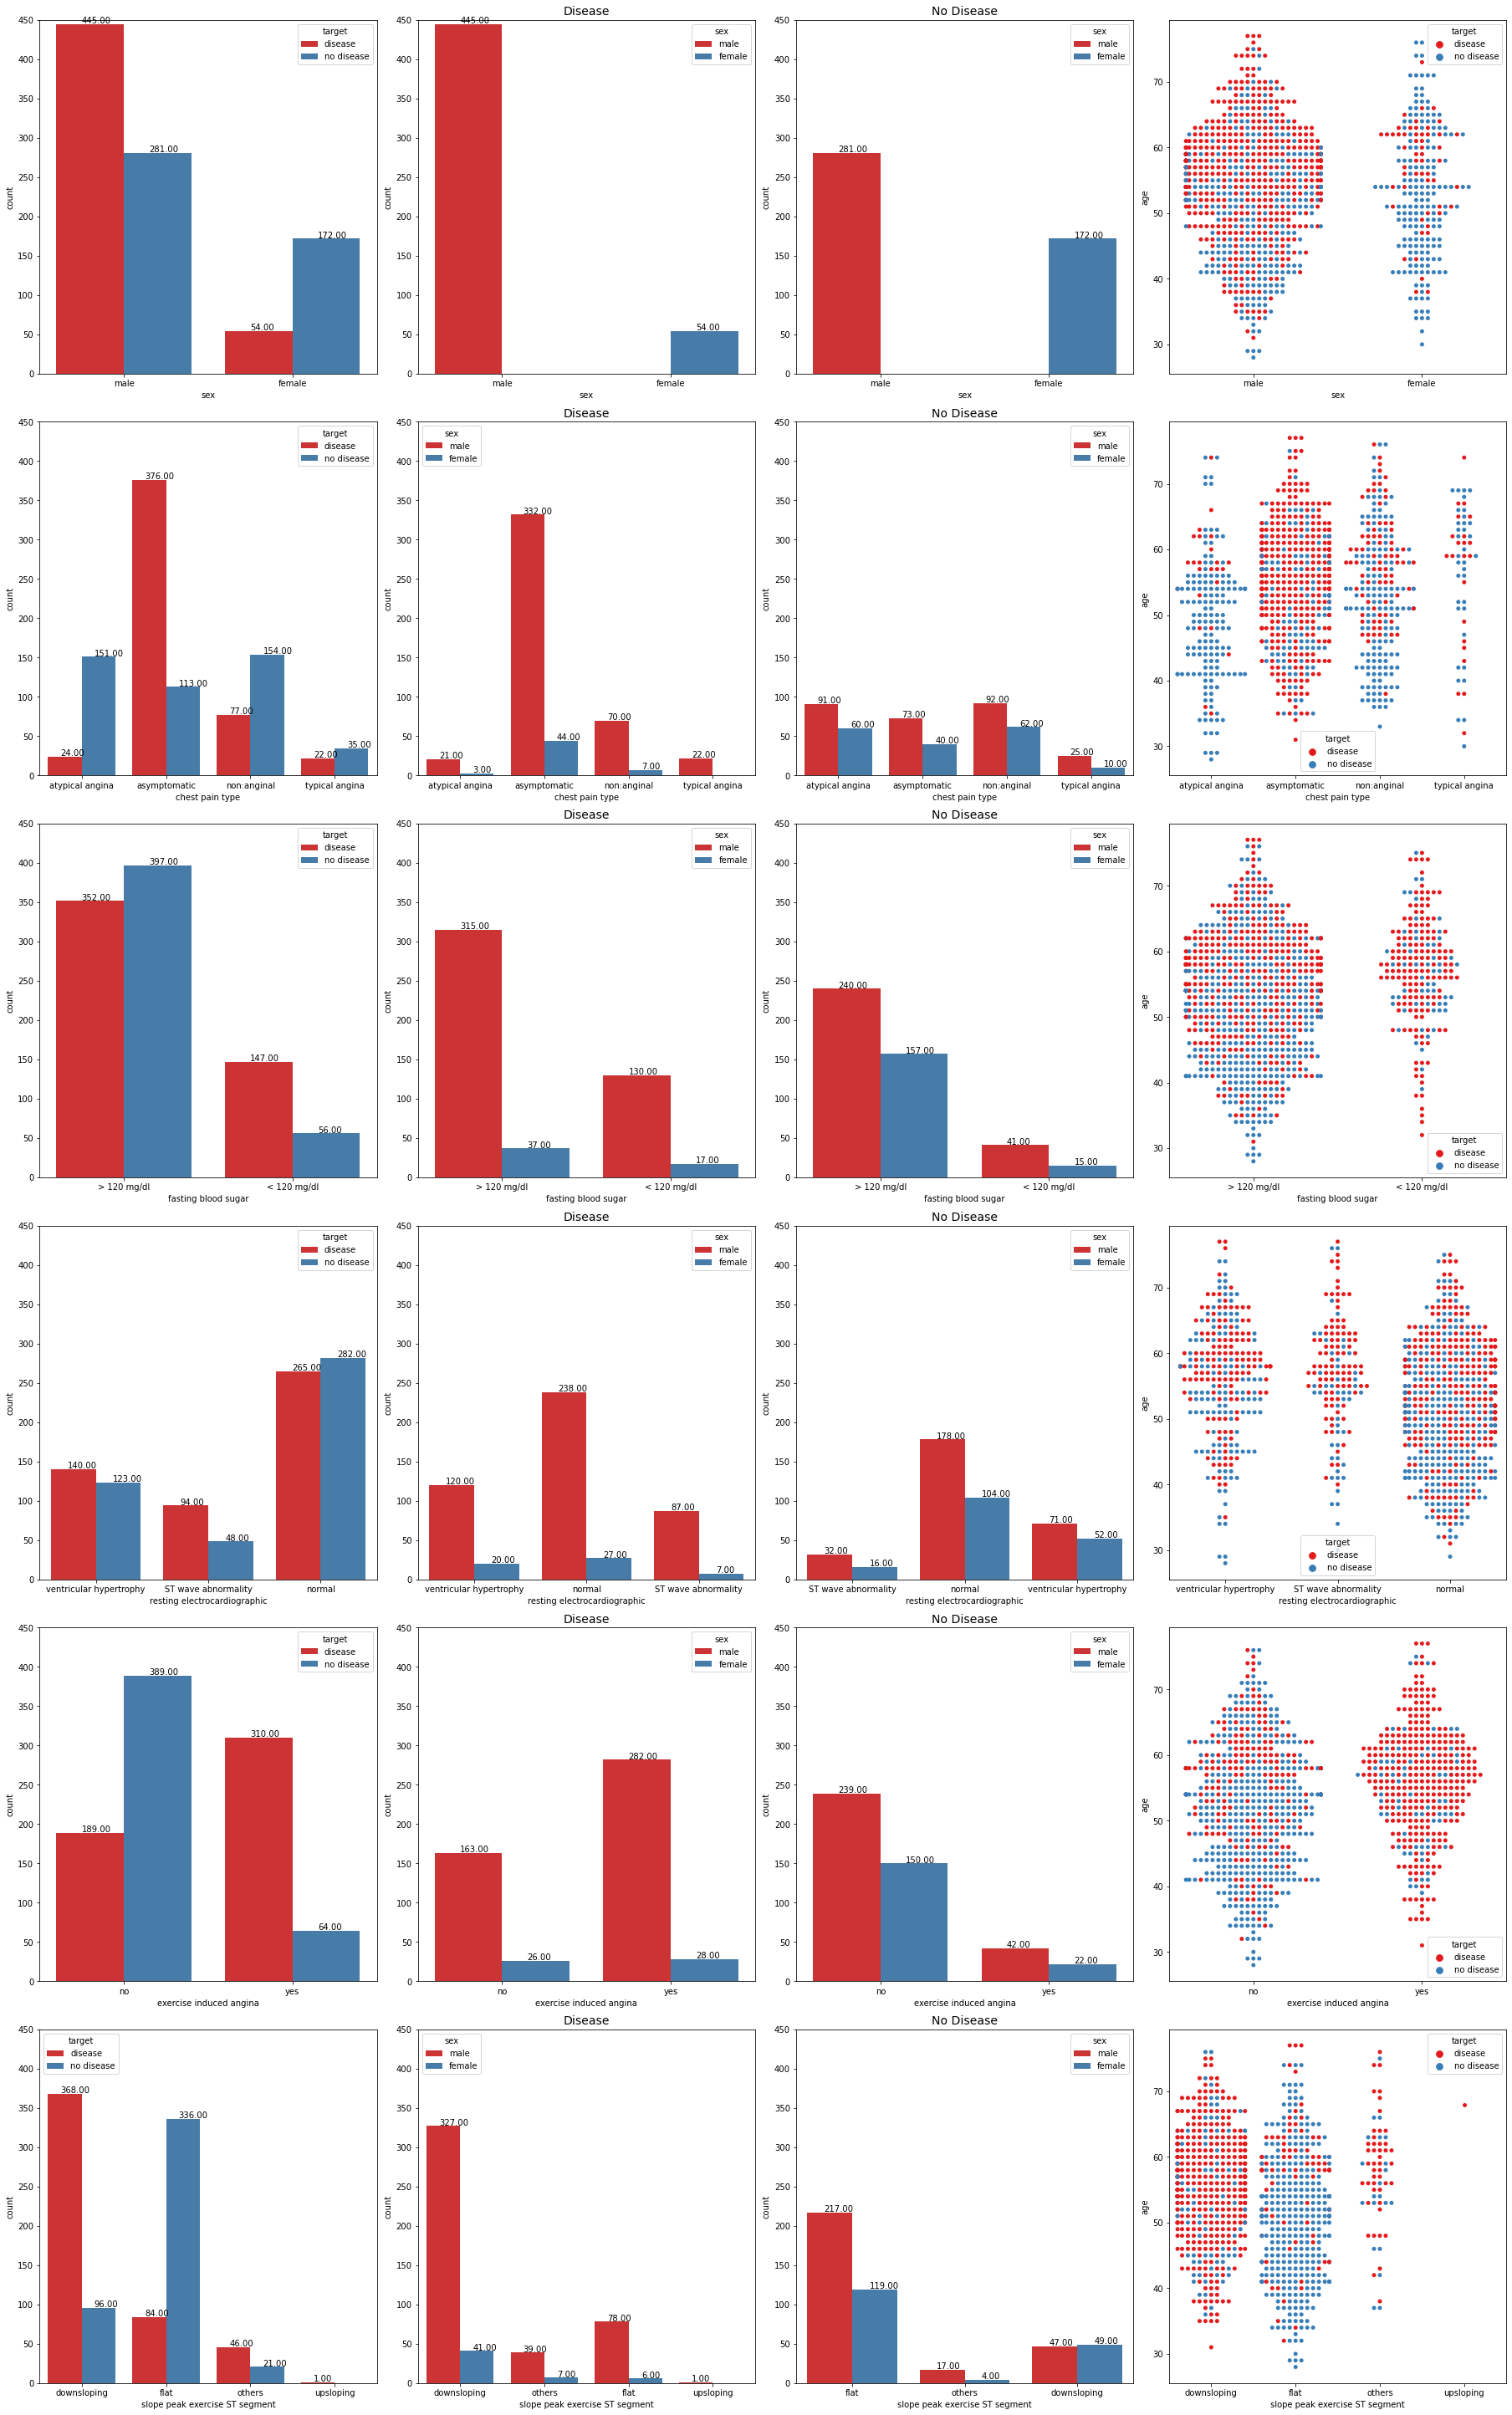

In [46]:
def plot_count_var(data:pd.DataFrame, x:str, hue:str, hue_order=None, ax:plt.Axes=None, palette:str=None, title:str=None):
    graph = sns.countplot(data=data, x=x, hue=hue, hue_order=hue_order, ax=ax, palette=palette)
    for p in graph.patches:
        graph.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    graph.set_title(title, fontsize=14)
    graph.set_ylim([0,450])

def plot_cat_var(data:pd.DataFrame, cols:list[str]):
    sub_num_of_row = len(cols)
    sub_num_of_col = 4     # three columns: overall, no disease, disease

    _, axs = plt.subplots(nrows=sub_num_of_row, ncols=sub_num_of_col, figsize=(25, 40), constrained_layout = True)


    for i in range(sub_num_of_row):
    
        plot_count_var(data=data, x=cols[i], hue='target', ax=axs[i][0], palette='Set1')
        plot_count_var(data=data[data['target']=="disease"], x=cols[i], hue='sex', ax=axs[i][1], palette='Set1', title="Disease")
        plot_count_var(data=data[data['target']=="no disease"], x=cols[i], hue='sex', ax=axs[i][2], palette='Set1', title="No Disease")
        
        graph = sns.swarmplot(data=data, x=cols[i], y='age', hue='target', ax=axs[i][3], palette='Set1')


plot_cat_var(cat_data, cat_cols)

### Numerical data
The conclusions is the following features play good role to identify presence or absence of the disease:
- **max heart rate** 
- **age** 
- **ST depression**


In [32]:
numeric_data = train_w_cat_data[num_cols+['target']]
# num_disease = numeric_data[numeric_data['target'] == 'disease']
# num_no_disease = numeric_data[numeric_data['target'] == 'no disease']

# num_desired_data = {
#     0: {"title":"DISEASE, target = 1", "data":num_disease,"pal":"Reds"},
#     1: {"title":"NO DISEASE, target = 0", "data":num_no_disease, "pal":"Blues"},
#     2: {"title":"Overall - {}", "data":numeric_data, "pal":"Set1"},
# }


#### Histogram - Probability
**Cholesterol** and **ST depression** are not follow the normal distribution<br>
so we will transform them to be normally distributed

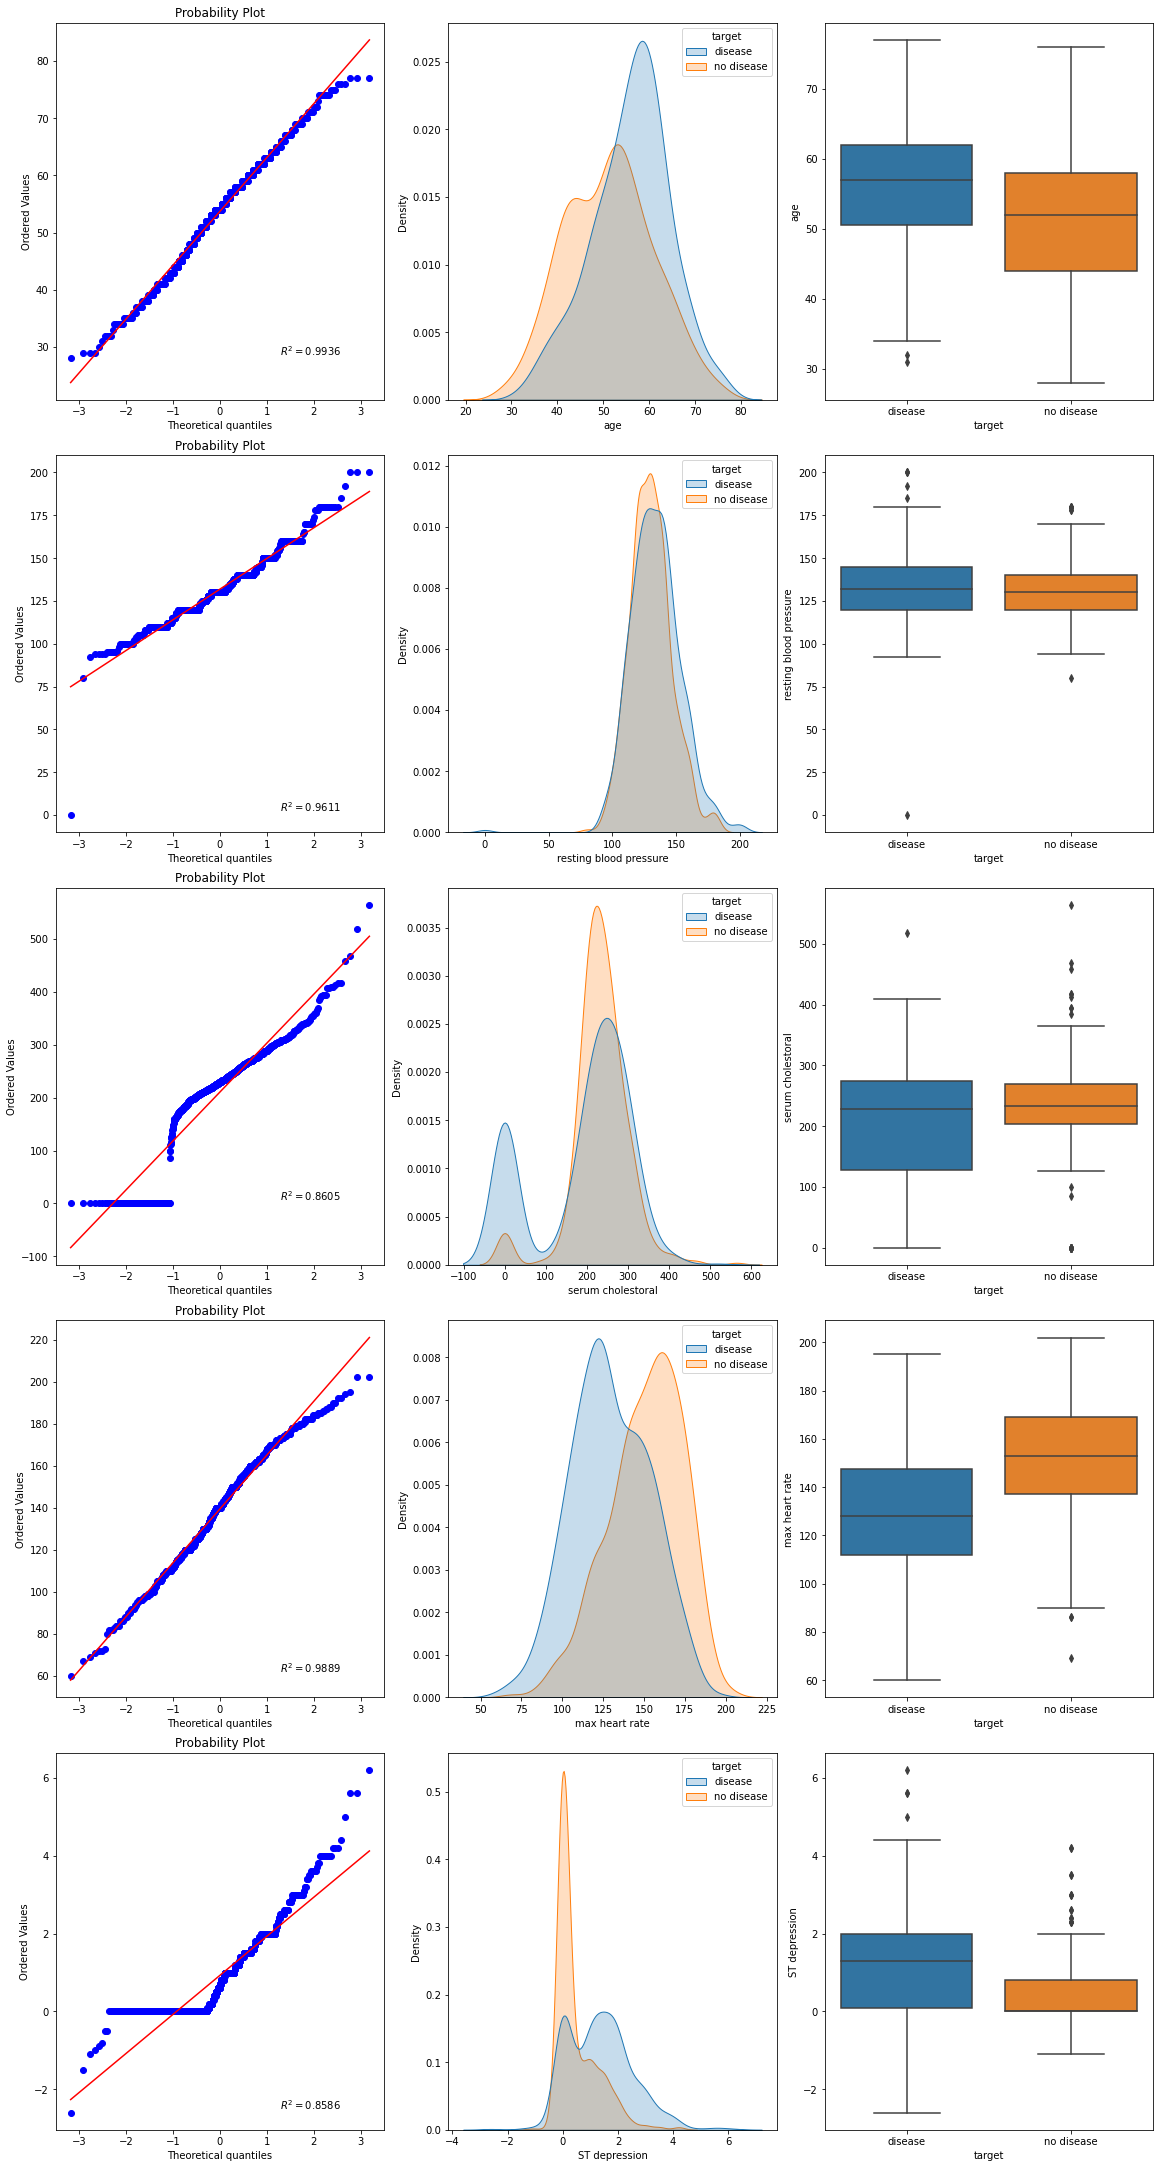

In [82]:
def plot_num_var(data):
    sub_num_of_row = len(num_cols)
    sub_num_of_col = 3     # three columns: overall, no disease, disease

    _, axs = plt.subplots(nrows=sub_num_of_row, ncols=sub_num_of_col, figsize=(16, 30), constrained_layout = True)


    for i in range(sub_num_of_row):
        stats.probplot(x= data[num_cols[i]], plot=axs[i][0], rvalue=True)
        sns.kdeplot(data=data, x=num_cols[i], hue='target', fill=True, ax=axs[i][1])
        sns.boxplot(data=data, y=num_cols[i], x='target', ax=axs[i][2])
        
#        
plot_num_var(numeric_data)

#### Pairplot

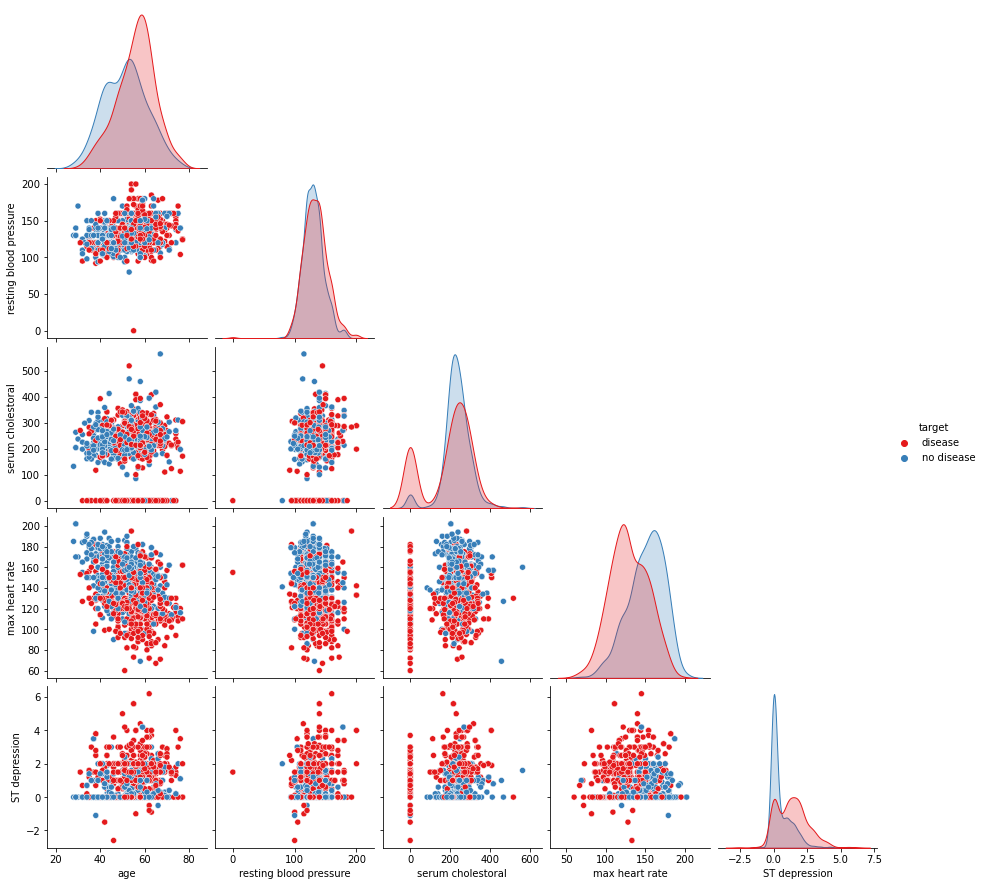

In [56]:
sns.pairplot(data=numeric_data, hue='target', corner=True, palette='Set1')

# Feature engineering

## Normality

In [13]:

                         
# train_data[["cholesterol","ST depression"]] = qt.fit_transform(train_data[["cholesterol","ST depression"]])
# test_data[["cholesterol","ST depression"]] = qt.transform(test_data[["cholesterol","ST depression"]])


## Selection

### Filter methods
The current problem contains independent features with categorical target. <br>
Therefore the desired filter methods to be used are **Chi2** and **LDA**:
1. For measuring the independence between Continues features and categorical target, The LDA algorithm should be used because:
    - LDA: Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.

2. For measuring the independence between categorical features and categorical target, The chi2 test should be used because:
    - Chi-Square: It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.

#### Correlation

<AxesSubplot:>

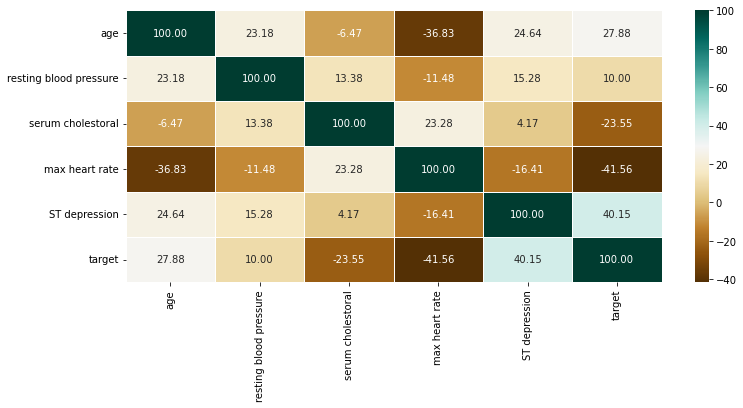

In [16]:
corr_values = train_data[num_cols+['target']].corr()

plt.figure(figsize=(12,5))
sns.heatmap(corr_values*100, linecolor='w', linewidths=1, annot=True, fmt='.2f', cmap = plt.cm.BrBG)

#### Multicollinearity Detecting
Variable Inflation Factors (VIF):
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In conclusion, No multicollinearity found between numeric features

In [17]:
vif = pd.DataFrame()
vif_corr_values = train_data[num_cols].corr()
vif["variables"] = vif_corr_values.columns
vif["VIF"] = [variance_inflation_factor(vif_corr_values.values, i) for i in range(vif_corr_values.shape[1])]
vif

,variables,VIF
0,age,2.26696
1,resting blood pressure,1.43110
2,serum cholestoral,1.40618
3,max heart rate,2.18110
4,ST depression,1.39275


#### Drawing test scores - bar plot

In [18]:
@dataclass
class TestResult:
    """class for storing test results"""
    specs: list[str]
    scores: list[Union[int, float]]
    res: pd.DataFrame = field(init=False, repr=False)

    def __post_init__(self):
        # Grouping results in DataFrame
        self.res = pd.DataFrame()
        self.res['Specs'] = self.specs
        self.res['Score'] = self.scores

@dataclass
class FeatureRank:
    """class for holding feature ranking"""
    func: Callable[[pd.DataFrame, pd.DataFrame], list[int]]
    X: pd.DataFrame
    y: pd.DataFrame
    test_result: TestResult = field(init=False)

    
    def __post_init__(self):
        
        # Take copy of X and y
        X_np = self.X.to_numpy()
        y_np = self.y.to_numpy()

        # Calculate feature ranking
        ret = self.func(X_np, y_np)

        # Create test result
        ranks = ret[0] if(len(ret)==2) else ret

        # Normalize ranks
        ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())

        self.test_result = TestResult(self.X.columns, ranks)

        # Change the index of the DataFrame
        self.test_result.res.index = [train_data.columns.get_loc(spec) for spec in self.test_result.res['Specs']]
    
    def get_largest_score(self, n:Union[int, str] = 'auto') -> list[str]:
        """Get the largest n scores"""
        if(isinstance(n, str) and n=='auto'):
            n = self.test_result.res.shape[0]
        
        return self.test_result.res.nlargest(n, columns=['Score'])['Specs'].values.tolist()

    def feat_imp_plot(self, title, sorting=False):
        """Plot feature importance as bar plot"""

        # Take copy of result to avoid modifying on original result
        result = self.test_result.res.copy()
        
        if(sorting):
            result = result.sort_values(by='Score', ascending=False)
            
        fig = plt.figure(figsize=(20,8))
        ax  = fig.add_subplot()
        axs = sns.barplot(x='Specs', y='Score', data=result, palette = 'Reds_r', ax=ax)
        for p in axs.patches:
            axs.annotate('{:.2f}'.format(p.get_height()), (p.get_x(), p.get_height()))
        plt.box(False)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('\n Features')
        ax.set_ylabel('Importance \n')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=30)

        return ax

        

#### Chi2 Test
Depending on the p_values and the previous categorical features plots we conclude.<br>
The following features demonstrate significant difference that help in distinguishing CAD diseases:
- exercise induced angina
- slope peak exercise ST segment
- chest pain type
- fasting blood sugar


,Specs,Score
1,sex,0.11188
2,chest pain type,0.34995
5,fasting blood sugar,0.31707
6,resting electrocardiographic,0.00000
8,exercise induced angina,1.00000
10,slope peak exercise ST segment,0.41839


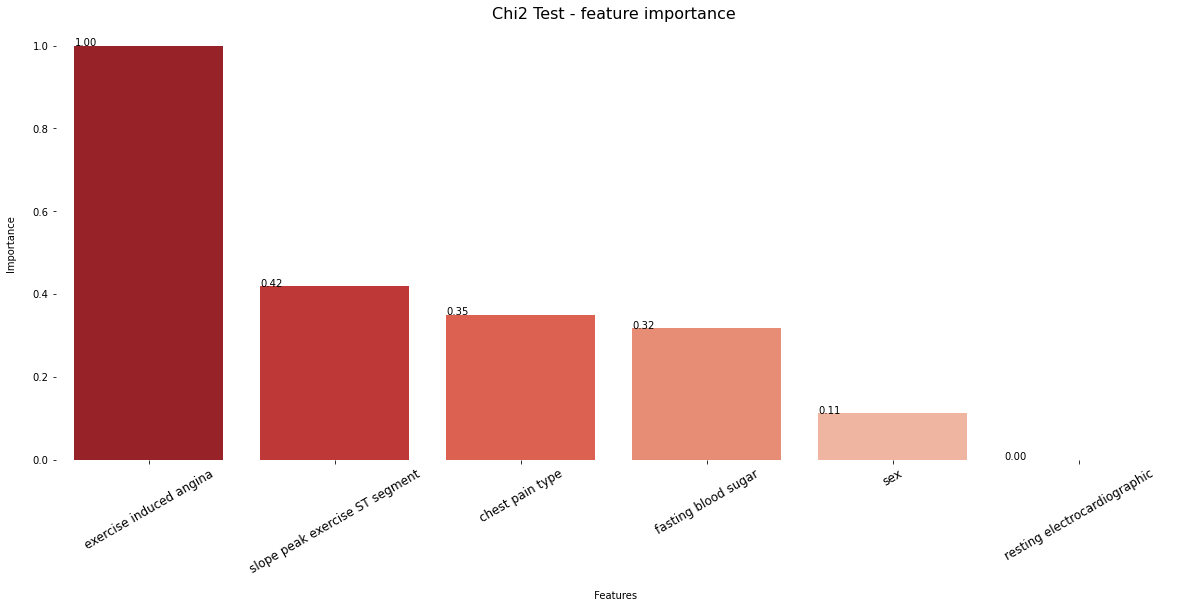

In [19]:
chi2_rank = FeatureRank(chi2, train_data[cat_cols], train_data['target'])
chi2_rank.feat_imp_plot('Chi2 Test - feature importance', sorting=True)
chi2_rank.test_result.res

#### ANOVA Test
Depending on the p_values and the previous numerical features plots we conclude.<br>
The following features demonstrate significant difference that help in distinguishing CAD diseases:
- max heart rate
- ST depression
- age
- cholesterol


<AxesSubplot:title={'center':'ANOVA Test - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

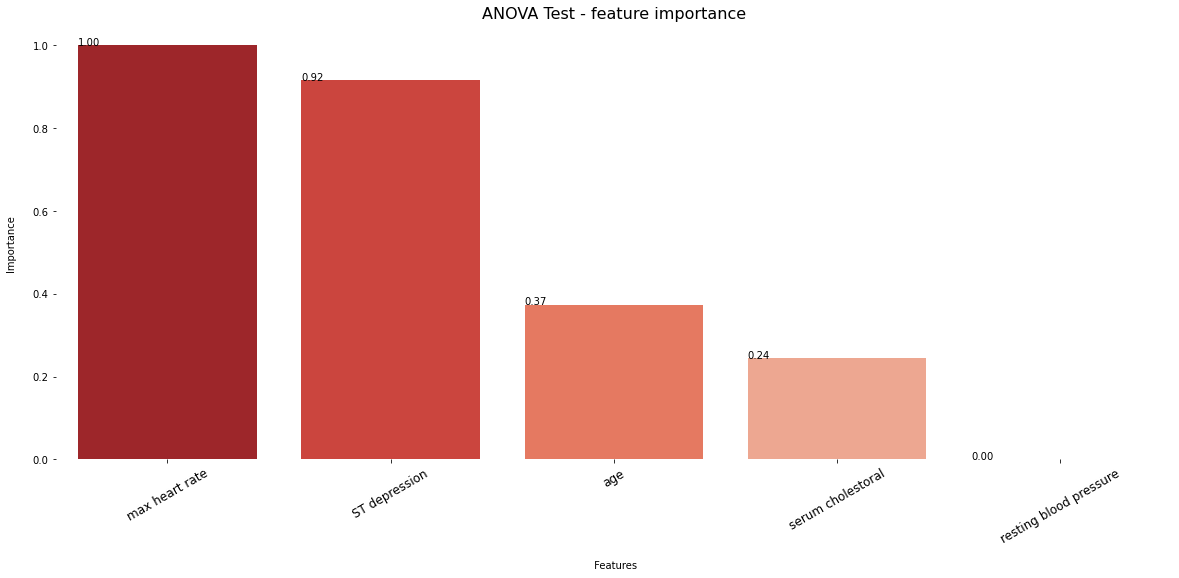

In [20]:
f_rank = FeatureRank(f_classif, train_data[num_cols], train_data['target'])
f_rank.feat_imp_plot('ANOVA Test - feature importance', sorting=True)

#### Mutual-info method

<AxesSubplot:title={'center':'Mutual-info Test - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

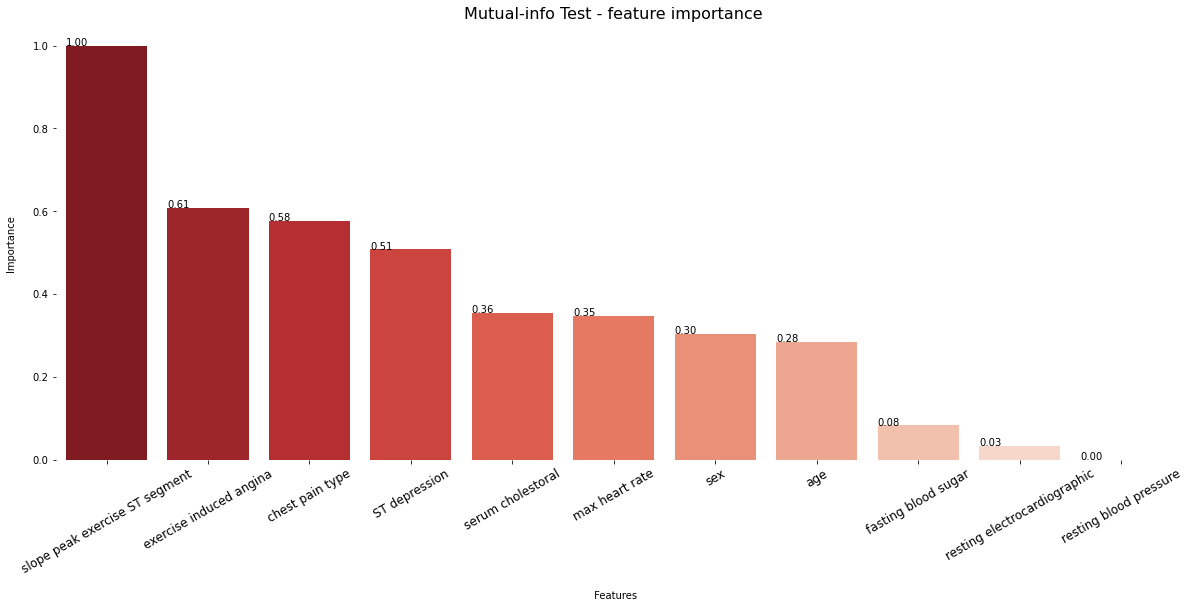

In [21]:
mi_rank = FeatureRank(mutual_info_classif, train_data.iloc[:,:-1], train_data['target'])
mi_rank.feat_imp_plot('Mutual-info Test - feature importance', sorting=True)

#### Fisher's Score

<AxesSubplot:title={'center':'Fisher Score - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

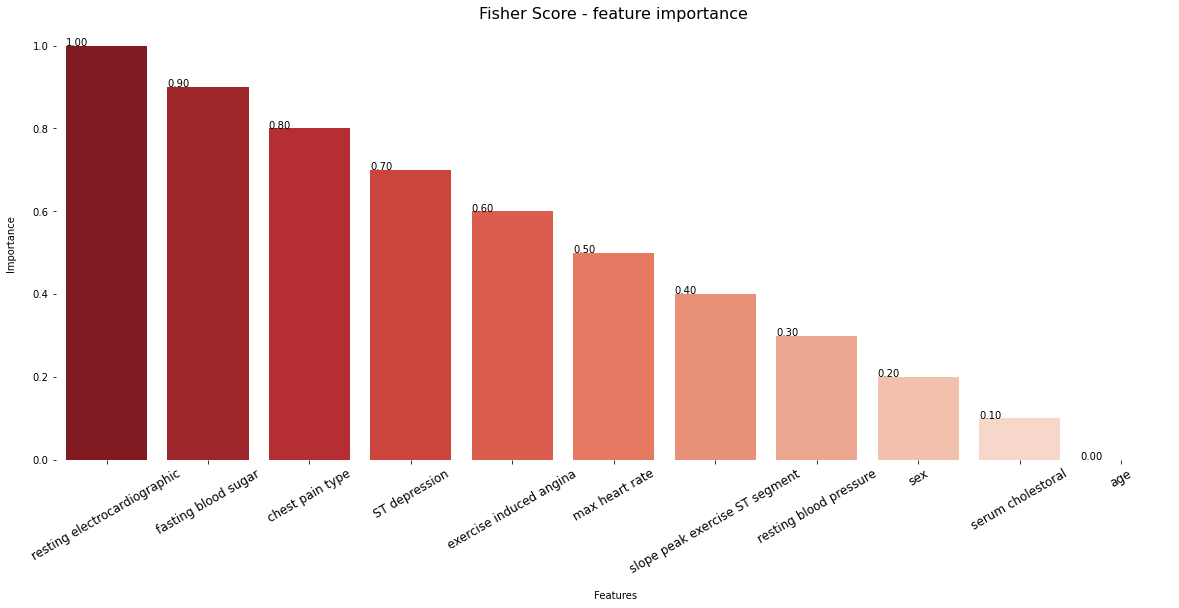

In [22]:
fisher_rank = FeatureRank(fisher_score, train_data.iloc[:,:-1], train_data['target'])
fisher_rank.feat_imp_plot('Fisher Score - feature importance', sorting=True)

#### Comparison

In [23]:
filter_methods_comp = pd.DataFrame()
filter_methods_comp = pd.concat([filter_methods_comp, mi_rank.test_result.res['Score']], axis=1)
filter_methods_comp = pd.concat([filter_methods_comp, fisher_rank.test_result.res['Score']], axis=1)
filter_methods_comp = pd.concat([filter_methods_comp, chi2_rank.test_result.res['Score']], axis=1)
filter_methods_comp = pd.concat([filter_methods_comp, f_rank.test_result.res['Score']], axis=1)
filter_methods_comp.index = index=train_data.columns[:-1]
filter_methods_comp.columns = ['mutual_info', 'fisher', 'chi2', 'anova']
filter_methods_comp.sort_values(by='mutual_info', ascending=False)


,mutual_info,fisher,chi2,anova
slope peak exercise ST segment,1.00000,0.4,0.41839,NaN
exercise induced angina,0.60817,0.6,1.00000,NaN
chest pain type,0.57674,0.8,0.34995,NaN
ST depression,0.50827,0.7,NaN,0.91640
serum cholestoral,0.35540,0.1,NaN,0.24471
max heart rate,0.34814,0.5,NaN,1.00000
sex,0.30408,0.2,0.11188,NaN
age,0.28468,0.0,NaN,0.37357
fasting blood sugar,0.08341,0.9,0.31707,NaN
resting electrocardiographic,0.03368,1.0,0.00000,NaN


### Wrapper methods

#### RFE

In [24]:
def rfe_score(X, y):
    """Calculate RFE score"""
    selection_svc_model = DecisionTreeClassifier()
    rfe = RFE(selection_svc_model, n_features_to_select=7, step=1)
    rfe.fit(X, y)

    return rfe.ranking_

rfe_rank = FeatureRank(rfe_score, train_data.iloc[:,:-1], train_data['target'], train_data.columns[:-1])
rfe_rank.feat_imp_plot('RFE Score - feature importance', sorting=True)



TypeError: __init__() takes 4 positional arguments but 5 were given

#### SFS

##### built-in library

In [ ]:

def sfs_score(X, y):
    sk_sfs_selector = sk_SFS(
    KNeighborsClassifier(n_neighbors=3), 
    direction='forward',
    scoring='accuracy',
    cv=10, 
    n_jobs=-1
    ).fit(X, y)
    sk_sfs_features = np.array(train_data.columns[:-1])[sk_sfs_selector.get_support()]
    return sk_sfs_features


sfs_score(train_data.iloc[:,:-1], train_data['target'])
sfs_rank = FeatureRank(sfs_score, train_data.iloc[:,:-1], train_data['target'], train_data.columns[:-1])
sfs_rank.feat_imp_plot('SFS Score - feature importance', sorting=True)


##### Diff library

In [25]:
def sfs_score(X, y):
    mlx_sfs_selector = mlx_SFS(
        DecisionTreeClassifier(), 
        k_features=X.shape[1],
        forward=True,
        floating=False,
        scoring='accuracy',
        cv=10,
        n_jobs=-1,
    ).fit(X, y)
    # mlx_sfs_features = mlx_sfs_selector.k_feature_names_
    mlx_sfs_scores = mlx_sfs_selector.get_metric_dict()
    return mlx_sfs_scores

# sfs_rank = FeatureRank(sfs_score, train_data.iloc[:,:-1], train_data['target'], train_data.columns[:-1])
# sfs_rank.feat_imp_plot('SFS Score - feature importance', sorting=True)


# fig1 = plot_sfs(mlx_sfs_selector.get_metric_dict(), kind='std_dev')
# plt.title('Sequential Forward Selection (w. StdErr)')
# plt.grid()
# plt.show()

#### Genetic Algorithm

In [26]:
genetic_model_selector = GeneticSelectionCV(
    SVC(), cv=5, verbose=0,
    scoring="accuracy", max_features=11,
    n_population=100, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=10,
    caching=True, n_jobs=-1)
    
genetic_model_selector = genetic_model_selector.fit(train_data.iloc[:,:-1], train_data['target'])

genetic_features = train_data.columns[:-1][genetic_model_selector.support_]

### Embedded methods

#### Tree-Based

<AxesSubplot:title={'center':'Tree-Based - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

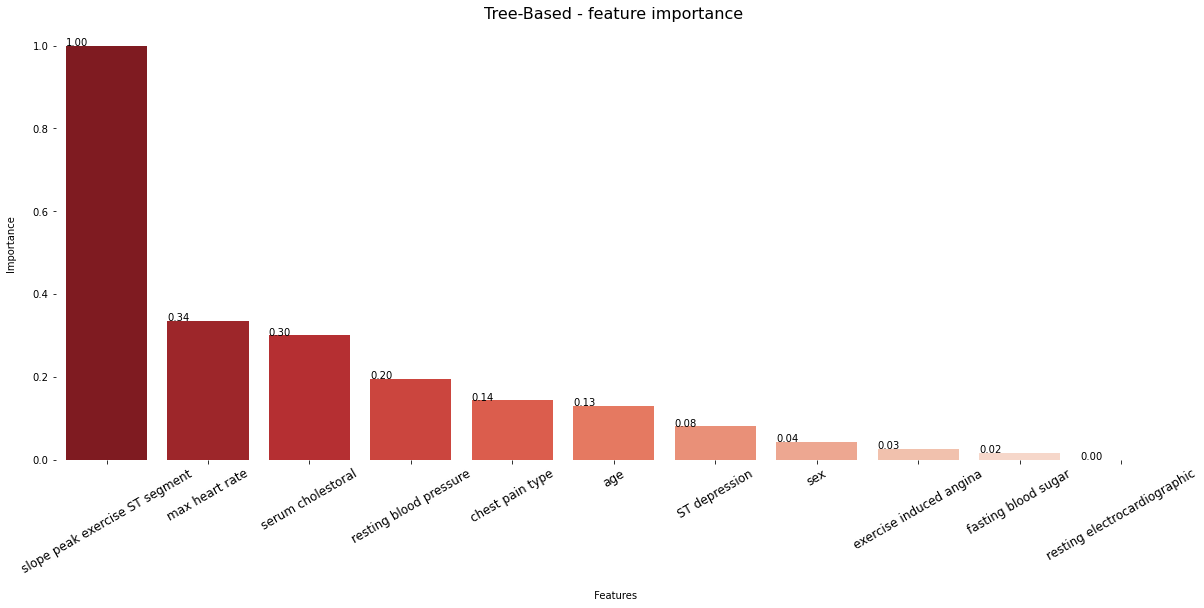

In [133]:
def tree_based_score(X, y):
    """Calculate Tree-based score"""
    dt_model_selector = DecisionTreeClassifier()
    dt_model_selector.fit(X, y)
    return dt_model_selector.feature_importances_

tree_based_rank = FeatureRank(tree_based_score, train_data.iloc[:,:-1], train_data['target'])
tree_based_rank.feat_imp_plot('Tree-Based - feature importance', sorting=True)

#### SVM (L1 regularization)

<AxesSubplot:title={'center':'SVM Score - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

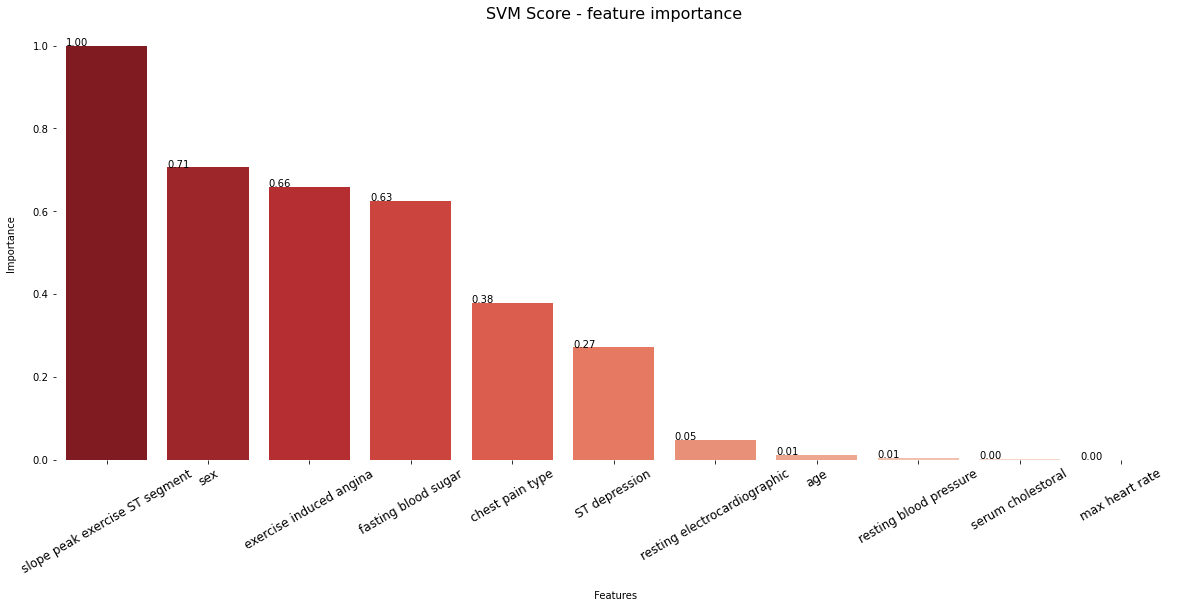

In [33]:
def svm_score(X, y):
    """Calculate SVM score"""
    svm_model_selector = SVC(kernel='linear')
    svm_model_selector.fit(X, y)
    return svm_model_selector.coef_.ravel()

svm_rank = FeatureRank(svm_score, train_data.iloc[:,:-1], train_data['target'])
svm_rank.feat_imp_plot('SVM Score - feature importance', sorting=True)



#### Lasso (L1 regularization)

<AxesSubplot:title={'center':'Lasso - feature importance'}, xlabel='\n Features', ylabel='Importance \n'>

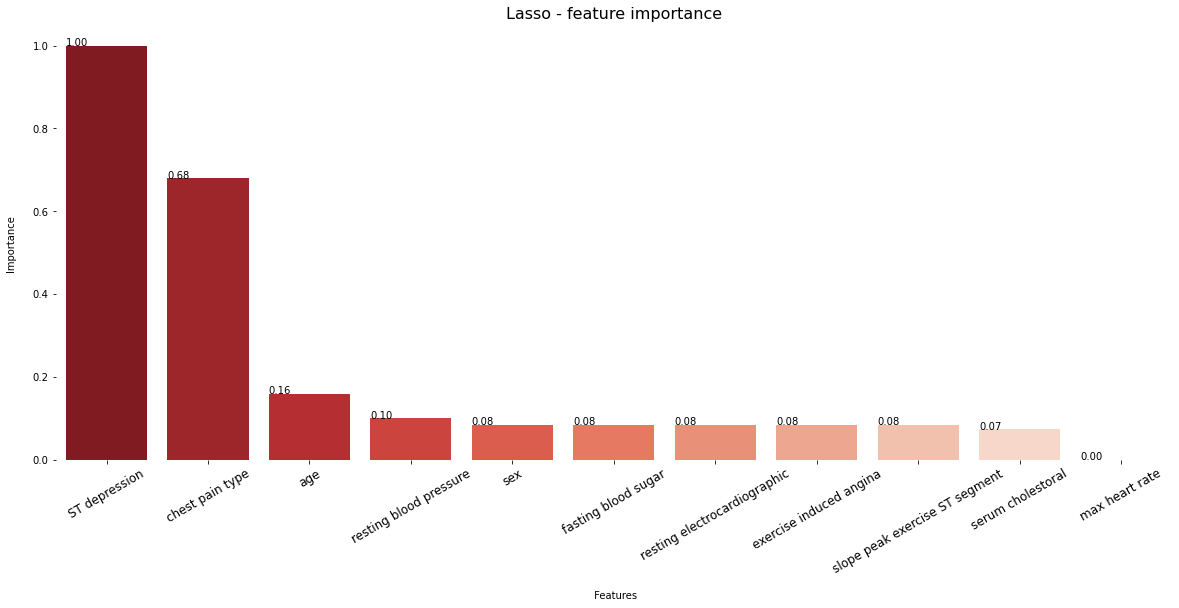

In [34]:
def lasso_score(X, y):
    """Calculate Lasso score"""
    lasso_model_selector = Lasso(alpha=0.1)
    lasso_model_selector.fit(X, y)
    return lasso_model_selector.coef_

lasso_rank = FeatureRank(lasso_score, train_data.iloc[:,:-1], train_data['target'])
lasso_rank.feat_imp_plot('Lasso - feature importance', sorting=True)

#### Comparison

In [35]:
embedded_methods_comp = pd.DataFrame()
embedded_methods_comp = pd.concat([embedded_methods_comp, tree_based_rank.test_result.res['Score']], axis=1)
embedded_methods_comp = pd.concat([embedded_methods_comp, svm_rank.test_result.res['Score']], axis=1)
embedded_methods_comp = pd.concat([embedded_methods_comp, lasso_rank.test_result.res['Score']], axis=1)
embedded_methods_comp.index = index=train_data.columns[:-1]
embedded_methods_comp.columns = ['tree_based', 'svm', 'lasso']
embedded_methods_comp.sort_values(by='tree_based', ascending=False)


NameError: name 'tree_based_rank' is not defined

## Important Features
In comparison between graphs and statistical test, the conclusion about the most contribution features are:
   - for categorical features:
      1. **slope peak exercise ST segment** 
      2. **exercise induced angina** 
      3. **chest pain type**
      4. **sex**
   - for numerical features:
      1. **max heart rate** 
      2. **age** 
      3. **ST depression**

In [184]:
filter_embedded_comp = pd.concat([embedded_methods_comp, filter_methods_comp], axis=1)

# Save DataFrame in excel file
filter_embedded_comp.to_excel('filter_embedded_comp.xlsx')
filter_embedded_comp['Avg'] = filter_embedded_comp.sum(axis=1)

# Normalize Avg column
filter_embedded_comp['Avg'] = (filter_embedded_comp['Avg'] - filter_embedded_comp['Avg'].min()) / (filter_embedded_comp['Avg'].max() - filter_embedded_comp['Avg'].min()) 
filter_embedded_comp = filter_embedded_comp.sort_values('Avg', ascending=False)

In [185]:
filter_embedded_comp

,tree_based,svm,lasso,mutual_info,fisher,chi2,anova,Avg
slope peak exercise ST segment,1.00000,1.00000,0.08499,1.00000,0.4,0.41839,NaN,1.00000
ST depression,0.08037,0.27179,1.00000,0.52962,0.7,NaN,0.91640,0.87732
exercise induced angina,0.02674,0.65969,0.08499,0.63101,0.6,1.00000,NaN,0.72723
chest pain type,0.14360,0.37953,0.67925,0.60694,0.8,0.34995,NaN,0.71416
max heart rate,0.33605,0.00000,0.00000,0.49814,0.5,NaN,1.00000,0.52491
fasting blood sugar,0.01702,0.62514,0.08499,0.15272,0.9,0.31707,NaN,0.45308
sex,0.04274,0.70632,0.08499,0.18308,0.2,0.11188,NaN,0.22059
resting electrocardiographic,0.00000,0.04854,0.08499,0.11746,1.0,0.00000,NaN,0.19697
serum cholestoral,0.30007,0.00186,0.07341,0.35445,0.1,NaN,0.24471,0.14353
age,0.13003,0.01218,0.15899,0.28705,0.0,NaN,0.37357,0.10942


<AxesSubplot:>

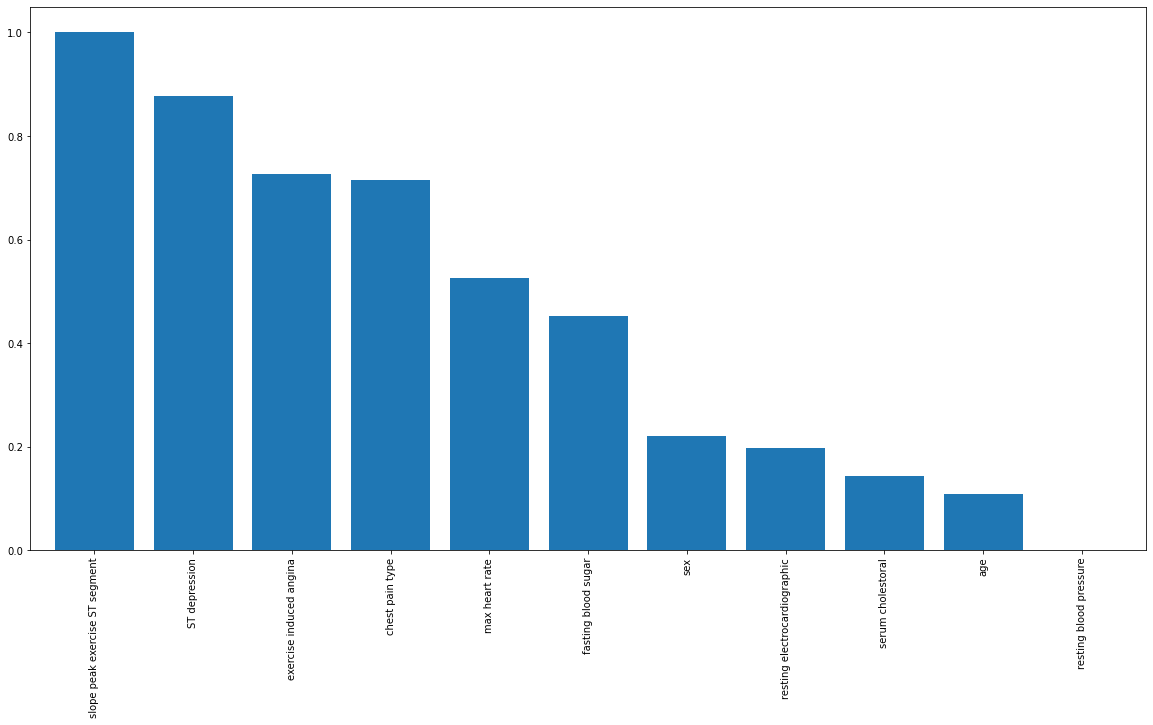

In [187]:
filter_embedded_comp['Avg'].plot.bar(width=0.8, figsize=(20,10))

In [177]:
mi_rank.get_largest_score(n=8), filter_embedded_comp.nlargest(8, 'Avg').index.to_list()

(['slope peak exercise ST segment',
  'exercise induced angina',
  'chest pain type',
  'ST depression',
  'max heart rate',
  'serum cholestoral',
  'age',
  'sex'],
 ['slope peak exercise ST segment',
  'ST depression',
  'exercise induced angina',
  'chest pain type',
  'max heart rate',
  'fasting blood sugar',
  'sex',
  'resting electrocardiographic'])

## Selected Features

In [36]:
list(enumerate(train_data.columns[:-1], 1))

[(1, 'age'),
 (2, 'sex'),
 (3, 'chest pain type'),
 (4, 'resting blood pressure'),
 (5, 'serum cholestoral'),
 (6, 'fasting blood sugar'),
 (7, 'resting electrocardiographic'),
 (8, 'max heart rate'),
 (9, 'exercise induced angina'),
 (10, 'ST depression'),
 (11, 'slope peak exercise ST segment')]

In [46]:

gg = [
    'chest pain type',
    'resting electrocardiographic',
    'max heart rate',
    'exercise induced angina',
    'ST depression',
    'target'
]
# gg = filter_embedded_comp.nlargest(8, 'Avg').index.to_list() + ['target']
selected_train_data = train_data[gg] 
selected_test_data = test_data[gg] 

# selected_train_data = train_data[genetic_features.tolist() + ['target']] 
# selected_test_data = test_data[genetic_features.tolist() + ['target']] 

## Scaling
Normalizing features helps to increase model's accuracy

In [47]:
scaled_train_data = selected_train_data.copy()
scaled_test_data = selected_test_data.copy()

# norm_scaler = MinMaxScaler()
# scaled_train_data[['max heart rate','ST depression']] = norm_scaler.fit_transform(scaled_train_data[['max heart rate','ST depression']])
# scaled_test_data[['max heart rate','ST depression']] = norm_scaler.transform(scaled_test_data[['max heart rate','ST depression']])


# X/y Split

In [48]:
@dataclass
class ModelData():
    X_train: pd.DataFrame 
    y_train: pd.DataFrame 
    X_test: pd.DataFrame 
    y_test: pd.DataFrame



# X_train = train_data.iloc[:,:-1]
# y_train = train_data.iloc[:,-1]
# X_test = test_data.iloc[:,:-1]
# y_test = test_data.iloc[:,-1]

X_train = scaled_train_data.iloc[:,:-1]
y_train = scaled_train_data.iloc[:,-1]
X_test = scaled_test_data.iloc[:,:-1]
y_test = scaled_test_data.iloc[:,-1]

model_data = ModelData(X_train, y_train, X_test, y_test)

print ('Train set:  ', X_train.shape,  y_train.shape)
print ('Test set:   ', X_test.shape,  y_test.shape)

Train set:   (777, 5) (777,)
Test set:    (238, 5) (238,)


# Model building

## Model Evaluation

In [49]:
class Report:
    def __init__(self, estimator: BaseEstimator, model_data: ModelData):
        self.estimator = estimator
        self.model_data = model_data

    def calc_cross_val(self):
        acc = cross_val_score(self.estimator, self.model_data.X_train, self.model_data.y_train, cv=10, scoring='accuracy').mean()
        print('Cross Validation Score (mean):  {:3.4%}'.format(acc))

    def calc_acc_val(self):   
        print('Train accuracy Score:  {:3.4%}'.format(self.estimator.score(self.model_data.X_train, self.model_data.y_train)))
        print('Test accuracy Score:  {:3.4%}'.format(self.estimator.score(self.model_data.X_test, self.model_data.y_test)))

    def confusion_mat(self):
        print(classification_report(self.model_data.y_test, self.estimator.predict(self.model_data.X_test)))

        _, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
        plot_confusion_matrix(self.estimator, self.model_data.X_test, self.model_data.y_test, ax=axs[0], cmap='Reds')
        plot_confusion_matrix(self.estimator, self.model_data.X_train, self.model_data.y_train, ax=axs[1], cmap='Reds')
        axs[0].set_title('Test')
        axs[1].set_title('Train')

    def roc_curve(self):
        try:
            _, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
            plot_roc_curve(self.estimator, self.model_data.X_train, self.model_data.y_train, ax=axs[0], color='r')
            axs[0].plot([0,1],[0,1], linestyle='--')
            axs[0].set_xlabel('False Positive Rate')
            axs[0].set_ylabel('True Positive Rate')
            axs[0].set_title('Train')
            plot_roc_curve(self.estimator, self.model_data.X_test, self.model_data.y_test, ax=axs[1], color='r')
            axs[1].plot([0,1],[0,1], linestyle='--')
            axs[1].set_xlabel('False Positive Rate')
            axs[1].set_ylabel('True Positive Rate')
            axs[1].set_title('Test')
        
        except ValueError as e:
            print("The ROC curve is not supported")


    def get_report(self):
        self.calc_cross_val()
        self.calc_acc_val()
        self.confusion_mat()
        self.roc_curve()


    

## Random Forest

Cross Validation Score (mean):  75.7959%
Train accuracy Score:  97.4260%
Test accuracy Score:  83.6134%
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       108
           1       0.89      0.80      0.84       130

    accuracy                           0.84       238
   macro avg       0.84      0.84      0.84       238
weighted avg       0.84      0.84      0.84       238



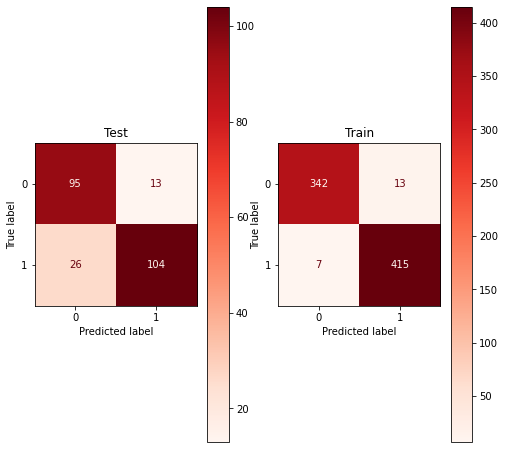

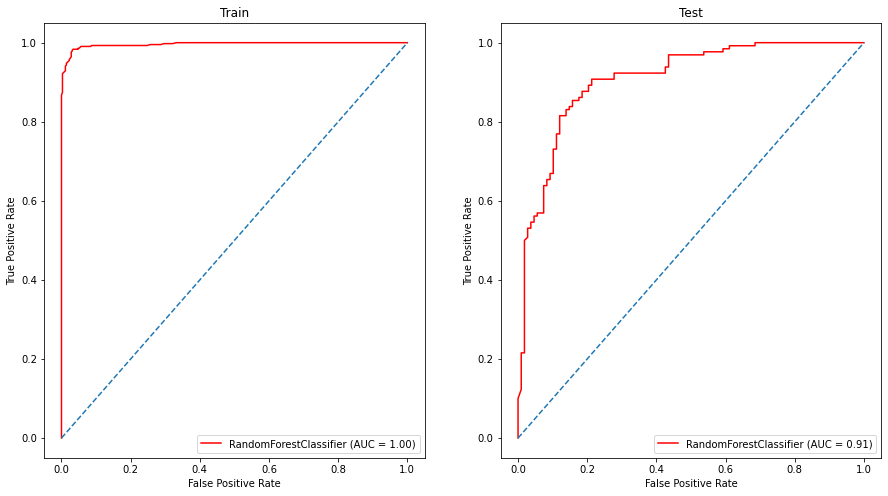

In [50]:
class RandomForestModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        params = {
            'max_depth':12, 
            'max_features':1, 
            'n_estimators':99,
            'random_state':0,
            'n_jobs':-1
        }
        self.model = RandomForestClassifier(**params)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X, y=None):
        return self.model.predict(X)
        

    def get_report(self, model_data: ModelData):
        report: Report = Report(self.model, model_data)
        return report.get_report()

rf_model = RandomForestModel()
rf_model.fit(X_train, y_train)
rf_model.get_report(model_data)

### Grid Search

In [51]:
param_grid = [
    {   'n_estimators': list(range(95, 100)),
        'max_depth': list(range(10, 15)), 
        'max_features': list(range(0,14)),
        'max_leaf_nodes': list(range(13,15))

    }
    
]

# grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=5, scoring='accuracy',cv=10, n_jobs=-1).fit(X_train,y_train)
# print('best estimator RandomForest:',grid_search_rf.best_estimator_, 'Best Score', grid_search_rf.best_estimator_.score(X_test, y_test))
# rf_best = grid_search_rf.best_estimator_


### Pipeline

In [52]:
# Create a class to select numerical or categorical columns 

# class DataValidation(BaseEstimator, TransformerMixin):
#     """Check data if it contains same attributes"""
#     def __init__(self):
#         ...
    
#     def fit(self, X, y=None):
#         return self
        
#     def transform(self, X):
#         cols_cnt = X.shape[1]
#         if(cols_cnt != 11):
#             raise ValueError('The number of columns is not equal to 11')
            
#         # change_features_name(X, output=False)  
#         return X.values

#     def fit_transform(self, X, y=None):
#         return self.fit(X,y).transform(X)
 
class MultiColumnNormality(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

        rng = np.random.RandomState(304)

        # n_quantiles is set to the training set size rather than the default value
        # to avoid a warning being raised by this example
        self.qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                                random_state=rng)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        output = X.copy()
 
        if self.attribute_names is not None:
            for col in self.attribute_names:
                if(col not in output.columns):
                    raise ValueError(f"The data doesn't have the attribute {col}")
                output[col] = self.qt.fit_transform(output[col].values.reshape(-1, 1))
        return output.values
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
class SelectFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, test_res:TestResult):
        self.test_res = test_res
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.test_res.get_largest_score(n=9)].values

    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)

validation_pipe = Pipeline([
    ('validation', DataValidation()),
])

normality_pipe = Pipeline(
    [
        ('normality', MultiColumnNormality(attribute_names=["cholesterol","ST depression"])),
    ]
)
selection_pipe = Pipeline(
    [
        ('selection', SelectFeatures(mi_rank.result)),
    ]
)

feat_modifier_pipe = FeatureUnion(transformer_list=
    [   
        ('validation', validation_pipe),
        ('normality', normality_pipe),
        ('selection', selection_pipe),
        ('scaler', MinMaxScaler()),
    ]
    ,n_jobs=-1)

feat_modifier_pipe.fit_transform(X_train).shape


# rf_pipe = Pipeline(steps=[
#     ('features_modifier', feat_modifier_pipe),
#     ('rf_model', rf_model),
# ])
# rf_pipe.fit(X_train, y_train)


NameError: name 'DataValidation' is not defined

## Voting

Cross Validation Score (mean):  82.5142%
Train accuracy Score:  99.8713%
Test accuracy Score:  92.4370%
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       108
           1       0.94      0.92      0.93       130

    accuracy                           0.92       238
   macro avg       0.92      0.93      0.92       238
weighted avg       0.93      0.92      0.92       238

The ROC curve is not supported


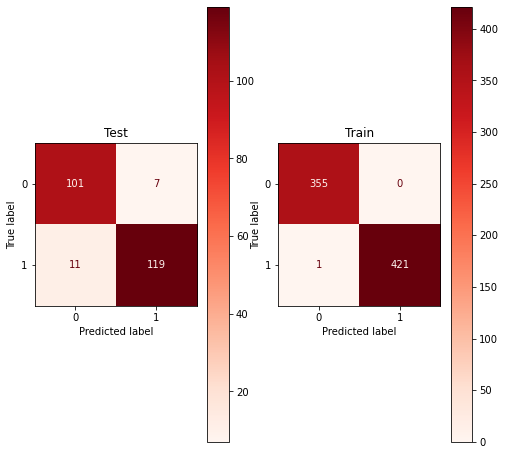

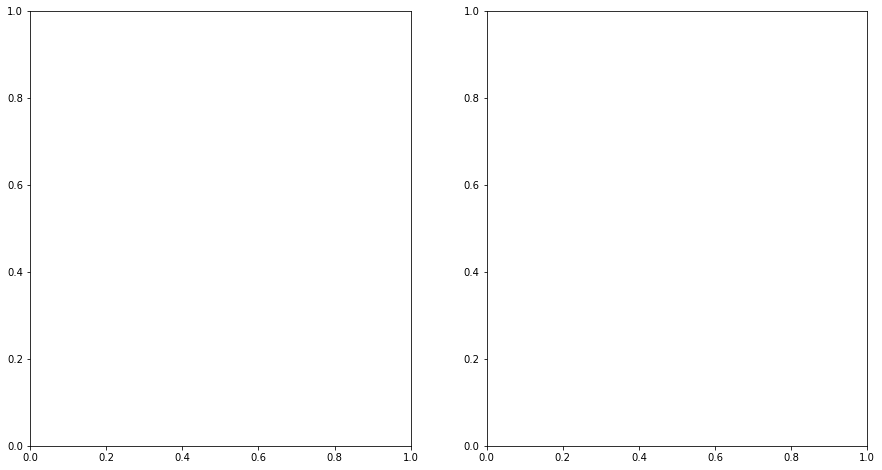

In [ ]:
class VotingClassifierModel(BaseEstimator, ClassifierMixin):
    def __init__(self, ):
        params = {
            "Random Forest":{  
                'max_depth':12, 
                'max_features':1, 
                'n_estimators':99, 
            },
            "Gradient Boosting":{
                'learning_rate':0.5,
                'max_depth':3,
                'min_samples_leaf':10,
                'random_state':0,
            },
        }
        
    
        clfs = (
            ('Random Forest1', RandomForestClassifier(**params['Random Forest'])),
            ('Random Forest2', RandomForestClassifier(**params['Random Forest'])),
            ('XGB1', GradientBoostingClassifier(**params['Gradient Boosting'])),
            ('XGB2', GradientBoostingClassifier(**params['Gradient Boosting'])),
            
        )
    

        self.model = VotingClassifier(clfs, n_jobs=-1)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X, y=None):
        return self.model.predict(X)
    
    def get_report(self, model_data: ModelData):
        report: Report = Report(self.model, model_data)
        return report.get_report()
        


ensemble_model = VotingClassifierModel()
ensemble_model.fit(X_train, y_train)
ensemble_model.get_report(model_data)
